In [2]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import time

import lzma, pickle
import scipy.fft as fft
import scipy.integrate as integ
import scipy.interpolate as interp
import scipy.optimize as optimize

import astropy.units as u
from astropy import constants as const

import rebound

# Peas in a Pod

Goal: get precession modes for a peas-in-a-pod system through two ways:
1. Numerical simulation
2. Analytical formula

For the values of $m$, and $a$, I use the Kepler-60 system:  
https://aasnova.org/2017/11/20/kepler-planets-tend-to-have-siblings-of-the-same-size/  
https://exoplanets.nasa.gov/exoplanet-catalog/369/kepler-60-b/  
https://exoplanets.nasa.gov/exoplanet-catalog/370/kepler-60-c/  
https://exoplanets.nasa.gov/exoplanet-catalog/371/kepler-60-d/  

The values of $e, i, f, \omega,$ and $\Omega$ are arbitrary.

# Rebound simulation 

In [3]:
sim = rebound.Simulation()
sim.units = ('yr', 'AU', 'Msun')

M_e = 3.00273e-6 # Earth mass in Msun

sim.add(m=1.0400)
sim.add(m=4.19*M_e, a=0.0719, e=0.05, f=4.3, omega=0.4, inc=0.1, Omega=3.3)
sim.add(m=3.85*M_e, a=0.0835, e=0.06, f=0.1, omega=1.4, inc=0.03, Omega=2.3)
sim.add(m=4.16*M_e, a=0.1012, e=0.02, f=1.6, omega=2.4, inc=0.07, Omega=0.8)

In [4]:
# visualize system before integration
# op_set = rebound.OrbitPlotSet(sim)

## Run sim

In [5]:
tstep = 1
tmax = 4096 # end time of integration (yr)
num_steps = int(tmax / tstep)

b_incs = np.asarray([0.] * num_steps) # inclination of Planet B over the simulation
c_incs = np.asarray([0.] * num_steps) # inclination of Planet C over the simulation
d_incs = np.asarray([0.] * num_steps) # inclination of Planet D over the simulation

b_as = np.asarray([0.] * num_steps) # semimajor axis of Planet B over the simulation
c_as = np.asarray([0.] * num_steps) # a of Planet C over the simulation
d_as = np.asarray([0.] * num_steps) # a of Planet D over the simulation

times = np.linspace(0, tmax, num_steps)

start = time.time()
for i, t in enumerate(times):
    # update inclination arrays
    b_incs[i] = sim.particles[1].inc
    c_incs[i] = sim.particles[2].inc
    d_incs[i] = sim.particles[3].inc
    
    # update semimajor axis arrays
    b_as[i] = sim.particles[1].a
    c_as[i] = sim.particles[2].a
    d_as[i] = sim.particles[3].a
    
    # move forward by one timestep
    sim.integrate(t)

print(f'Integration took {np.round(time.time() - start, 1)} seconds')

Integration took 193.7 seconds


In [6]:
# visualize system after integration
# op_set = rebound.OrbitPlotSet(sim)

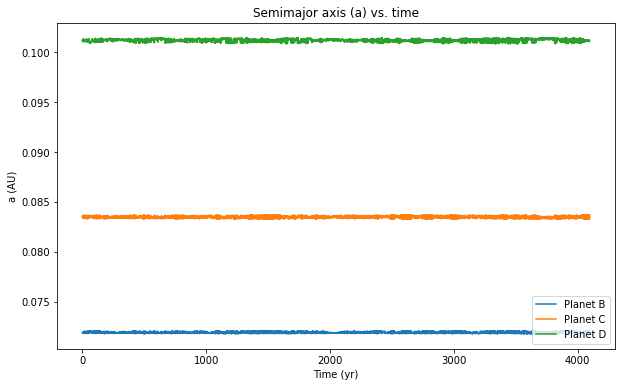

In [7]:
# check that semimajor axes aren't wandering
fig = plt.figure(figsize=(10,6))

plt.plot(times, b_as, label='Planet B')
plt.plot(times, c_as, label='Planet C')
plt.plot(times, d_as, label='Planet D')

plt.xlabel('Time (yr)')
plt.ylabel('a (AU)')

plt.title('Semimajor axis (a) vs. time')
plt.legend(loc='lower right')
plt.show()

In [8]:
# convert inclinations from radians to degrees
b_incs = b_incs * (180 / np.pi)
c_incs = c_incs * (180 / np.pi)
d_incs = d_incs * (180 / np.pi)

file_path = f'bcd_incs_%.1E_yrs.pkl' % tmax
with lzma.open(file_path, 'wb') as f:
    pickle.dump((times, b_incs, c_incs, d_incs), f)

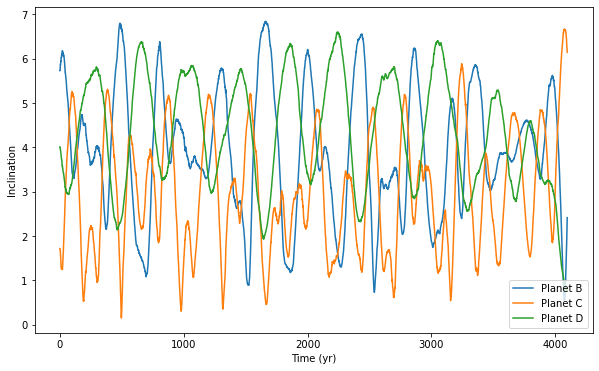

In [9]:
load_data = False

if load_data:    
    tmax = 2e3
    file_path = f'bcd_incs_%.1E_yrs.pkl' % tmax

    ## open old data files
    with lzma.open(file_path, 'rb') as f:
        times, b_incs, c_incs, d_incs = pickle.load(f)

fig = plt.figure(figsize=(10,6))

plt.plot(times, b_incs, label='Planet B')
plt.plot(times, c_incs, label='Planet C')
plt.plot(times, d_incs, label='Planet D')

plt.xlabel('Time (yr)')
plt.ylabel('Inclination')

plt.legend(loc='lower right')
plt.show()

## Run FFT (and interpolation)

In [ ]:
N = num_steps

# only look at the positive side of the FFT
yf = np.abs(fft.fft(d_incs - np.mean(d_incs))[:N//2])
yf_scaled = 2 / num_steps * np.abs(yf)
xf = fft.fftfreq(num_steps, tstep)[:N//2]

plt.plot(xf, yf_scaled)

plt.xlim(0, 0.02)
plt.show()

print(f'Period: {np.round(1 / (xf[np.argmax(yf)]), 3)} years')
print(f'Amplitude: {np.round(yf_scaled[np.argmax(yf)], 4)} degrees')

## Analytic formula

In [ ]:
def laplace_coeff_integrand(x, alpha):
    '''
    
    This function represents the integrand of the Laplace coefficient formula
    (Eq. 6.67 of Murray & Dermott). Following Eq. A3 in Su & Lai 2022, we
    use j=1 and s=3/2. The result is used in the laplace_coeff function.
    
    PARAMETERS
    ----------
    x: argument of the function
    alpha: variable that isn't integrated over
    
    '''
    
    num = np.cos(x) # numerator
    denom = (1 - 2 * alpha * np.cos(x) + alpha**2) ** (3/2)
    
    return num / denom

def laplace_coeff(alpha):
    '''
    
    Calculate the Laplace coefficient using Eq. 6.67 of Murray & Dermott.
    (This is the exact form of Eq. A3 in Su & Lai 2022.) The result is used 
    in mode_freq (and is denoted as "b").
    
    PARAMETERS
    ----------
    alpha: input to the formula.
    
    '''
    
    return 1 / np.pi * integ.quad(laplace_coeff_integrand, 0, 2*np.pi, args=(alpha))[0]
    
def mode_freq(a_j, a_k, m_k, M_star):
    
    '''
    
    Calculate the precession rate (w_jk) of the j-th planet 
    induced by the k-th planet.
    
    PARAMETERS
    ----------
    a_j, a_k: semimajor axes of planets j and k, respectively; assumes that
    parameters are provided with units (e.g., u.au or u.m)
    m_k, M_star: masses of planet k and the central star, respectively; assumes
    that parameters are provided with units (e.g., u.kg or u.M_sun)
    
    '''
    # np.min, max don't work with astropy quantities
    a_min, a_max = a_j, a_k
    if (a_k < a_j):
        a_min = a_k
        a_max = a_j
        
    n_j = np.sqrt(const.G * M_star / (a_j**3))
    alpha = a_min / a_max
    b = laplace_coeff(alpha)
    
    return m_k / (4 * M_star) * \
            (a_j * a_min) / (a_max**2) * \
            n_j * b

In [ ]:
a_b = sim.particles[1].a * u.au
a_c = sim.particles[2].a * u.au
a_d = sim.particles[3].a * u.au

M_star = sim.particles[0].m * u.M_sun
m_b = sim.particles[1].m * u.M_sun
m_c = sim.particles[2].m * u.M_sun
m_d = sim.particles[3].m * u.M_sun

planet_inds = ['b', 'c', 'd']

# calculate omega_jk values in yr^-1 (but without the unit)
# format: omega_jk = mode_freq(a_j, a_k, m_k, M_star).to(u.yr**-1).value
for j in planet_inds:
    for k in planet_inds:
        if (j == k): continue
        exec('omega_' + j + k + ' = ' + \
             'mode_freq(a_' + j + ', a_' + k +', m_' + k +', M_star).to(u.yr**-1).value')

The below cell gets the eigenvalues of the matrix in Eq. A1 of Su & Lai 2022.

In [ ]:
mat = np.array([
    [-omega_bc - omega_bd, omega_bc, omega_bd],
    [omega_cb, -omega_cb - omega_cd, omega_cd],
    [omega_db, omega_dc, -omega_db - omega_dc]
])

eigs, eigv = np.linalg.eig(mat)
prec_freqs = eigs[np.where(np.abs(eigs) > 1e-10)]
prec_eigvs = eigv[:, np.where(np.abs(eigs) > 1e-10)]
prec_eigvs = np.squeeze(prec_eigvs).T # reshape to (2,3), ie each row is an eigv

g_1, g_2 = -prec_freqs

In [ ]:
print(f'Period 1: {np.round(2 * np.pi / g_1, 3)} years')
print(f'Period 2: {np.round(2 * np.pi / g_2, 3)} years')

In [ ]:
# check that eigenvalues and eigenvectors match
print(f"Matrix \"divided\" by eigenvector 1: {np.matmul(mat, prec_eigvs[0]) / prec_eigvs[0]}")
print(f"Matrix \"divided\" by eigenvector 2: {np.matmul(mat, prec_eigvs[1]) / prec_eigvs[1]}")
print(f'Eigenvalues: {eigs}')